# Art Classification with Deep Convolutional Neural Networks

In [78]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Creating folder for augmented images

In [79]:
# make directories

os.makedirs('/content/drive/MyDrive/Github_Projects/train_augmented', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Github_Projects/test_augmented', exist_ok=True)

In [80]:
# Creating anImageDataGenerator
train_datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.25, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1)
valid_datagenerator = ImageDataGenerator(rescale=1./255)

# saving the augmented images in train and validation folders

train_augmented = train_datagenerator.flow_from_directory(directory='/content/drive/MyDrive/Github_Projects/train', target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training', shuffle=True, seed=123, color_mode='rgb', save_to_dir='/content/drive/MyDrive/Github_Projects/train_augmented',save_format='png', save_prefix='aug')
test_augmented = valid_datagenerator.flow_from_directory(directory='/content/drive/MyDrive/Github_Projects/test', target_size=(224, 224), batch_size=32, class_mode='categorical', save_to_dir='/content/drive/MyDrive/Github_Projects/test_augmented', save_format='png', save_prefix='aug')


Found 628 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [1]:
# importing the VGG19 model from keras

from tensorflow.keras.applications import VGG19

model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [82]:
# not training the VGG model layers

for layer in model.layers:
    layer.trainable = False

In [83]:
# Creating the custom model

custom_model = Sequential([
    model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

custom_model.summary()

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               6422784   
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 26480322 (101.01 MB)
Trainable params: 6455938 (24.63 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [84]:
# callbacks

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

Modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Github_Projects/best_model.h5', monitor='val_loss', save_best_only=True)

In [85]:
# history of the model training
history = custom_model.fit_generator(train_augmented, validation_data=test_augmented, epochs=50, verbose=1, callbacks=[es, Modelcheckpoint])

Epoch 1/50
20/20 [==============================] - 57s 3s/step - loss: 1.5051 - accuracy: 0.5350 - precision: 0.5350 - recall: 0.5350 - val_loss: 0.7084 - val_accuracy: 0.6119 - val_precision: 0.6119 - val_recall: 0.6119
Epoch 2/50
20/20 [==============================] - 50s 3s/step - loss: 0.6528 - accuracy: 0.6513 - precision: 0.6513 - recall: 0.6513 - val_loss: 0.5213 - val_accuracy: 0.7313 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 3/50
20/20 [==============================] - 53s 3s/step - loss: 0.5642 - accuracy: 0.7261 - precision: 0.7261 - recall: 0.7261 - val_loss: 0.4782 - val_accuracy: 0.7537 - val_precision: 0.7537 - val_recall: 0.7537
Epoch 4/50
20/20 [==============================] - 52s 3s/step - loss: 0.6137 - accuracy: 0.6959 - precision: 0.6959 - recall: 0.6959 - val_loss: 0.6462 - val_accuracy: 0.7388 - val_precision: 0.7388 - val_recall: 0.7388
Epoch 5/50
20/20 [==============================] - 53s 3s/step - loss: 0.5740 - accuracy: 0.7054 - precision: 0

In [86]:
# prompt: make predictions for an image

from tensorflow.keras.preprocessing import image
import numpy as np

image_path = '/content/drive/MyDrive/Github_Projects/test/Ai/robot-monitoring-dairy-farm-1200x800-1.jpg' # define the path
img = image.load_img(image_path, target_size=(224, 224))    # load the image
img_array = image.img_to_array(img)                      # convert the image to array
img_batch = tf.keras.applications.vgg19.preprocess_input(img_array)   # preprocess_input
img_batch = np.expand_dims(img_array, axis=0)     # adding 1 more dimension
predictions = custom_model.predict(img_batch)     # making prediction
predicted_class = np.argmax(predictions)      # getting the most probable class

class_labels = list(train_augmented.class_indices.keys())  # getting the label index

print("Predicted class:", class_labels[predicted_class])     # printing the name


1/1 [==============================] - 0s 158ms/step
Predicted class: Real


In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

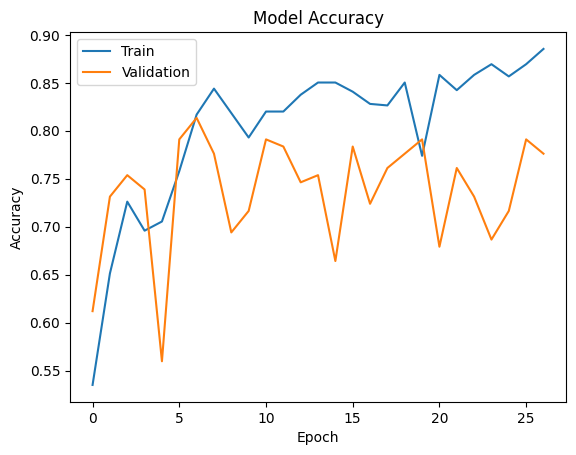

In [88]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'])
plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()